# 3. Potential Outcomes and RCTs (Julia Implementation)

This notebook implements analysis of potential outcomes and randomized controlled trials using Julia.

## Assignment Requirements:
1. **Data Simulation (3 points)**: Simulate dataset with covariates, treatment, and outcome
2. **Estimating Average Treatment Effect (3 points)**: Simple and controlled regression estimates
3. **LASSO and Variable Selection (3 points)**: Use LASSO for covariate selection and ATE estimation

In [17]:
# Import required libraries
using DataFrames
using GLMNet
using GLM
using Distributions
using Random
using Statistics
using Plots
using StatsBase
using HypothesisTests
using Printf
using CSV

# Set random seed for reproducibility
Random.seed!(123)

# Create output directory if it doesn't exist
output_dir = "../output"
if !isdir(output_dir)
    mkpath(output_dir)
end

println("📦 Libraries loaded successfully")
println("📁 Output directory ready: $output_dir")

📦 Libraries loaded successfully
📁 Output directory ready: ../output


## 3.1 Data Simulation (3 points)

### Assignment Requirements (2 points):

Simulate a dataset with n = 1000 individuals generating:

1. **Covariates X₁, X₂, X₃, X₄** (continuous or binary)
   - X₁, X₂: Continuous covariates  
   - X₃, X₄: Binary covariates

2. **Treatment assignment D ~ Bernoulli(0.5)**
   - Random treatment assignment with 50% probability

3. **Outcome variable following the exact specification:**
   $$Y = 2D + 0.5 X_1 - 0.3 X_2 + 0.2 X_3 + \epsilon, \quad \epsilon \sim N(0,1)$$
   
   Note: X₄ intentionally excluded (coefficient = 0) to test variable selection

4. **Save in a data.frame** structure (DataFrame in Julia)

In [18]:
# Set parameters
n = 1000

# Generate covariates
X1 = rand(Normal(2, 1), n)          # Continuous covariate
X2 = rand(Normal(0, 1.5), n)       # Continuous covariate
X3 = rand(Bernoulli(0.3), n)       # Binary covariate
X4 = rand(Bernoulli(0.6), n)       # Binary covariate

# Generate treatment assignment
D = rand(Bernoulli(0.5), n)        # Treatment ~ Bernoulli(0.5)

# Generate error term
ε = rand(Normal(0, 1), n)

# Generate outcome variable: Y = 2D + 0.5X1 - 0.3X2 + 0.2X3 + ε
Y = 2 .* D .+ 0.5 .* X1 .- 0.3 .* X2 .+ 0.2 .* X3 .+ ε

# Create DataFrame
data = DataFrame(
    Y = Y,
    D = D,
    X1 = X1,
    X2 = X2,
    X3 = X3,
    X4 = X4
)

println("📊 Dataset simulated successfully")
println("Sample size: $(nrow(data))")
println("Treatment group size: $(sum(data.D))")
println("Control group size: $(sum(1 .- data.D))")
println()

# Display first few rows
println("First 5 rows of the dataset:")
first(data, 5)

📊 Dataset simulated successfully
Sample size: 1000
Treatment group size: 484
Control group size: 516

First 5 rows of the dataset:


Row,Y,D,X1,X2,X3,X4
,Float64,Bool,Float64,Float64,Bool,Bool
1,3.50342,true,2.80829,0.897318,false,false
2,1.70251,false,0.877927,-1.5113,true,true
3,2.6304,true,0.895364,2.96885,false,false
4,0.700081,false,1.58301,-0.51933,false,true
5,2.94045,true,2.28759,1.88385,true,true


### Balance Check (1 point)

We perform a balance check by comparing the means of X₁, X₂, X₃, X₄ across treatment and control groups.

In [19]:
# Balance check: compare means across treatment groups using t-tests
control_group = data[data.D .== 0, :]
treatment_group = data[data.D .== 1, :]

println("🔍 Balance Check: Comparing Treatment and Control Groups")
println("="^60)

balance_results = DataFrame(
    Variable = String[],
    Control_Mean = Float64[],
    Treatment_Mean = Float64[],
    Difference = Float64[],
    Std_Error_Diff = Float64[],
    t_statistic = Float64[],
    p_value = Float64[],
    Balanced = String[]
)

for var in ["X1", "X2", "X3", "X4"]
    control_vals = control_group[:, var]
    treatment_vals = treatment_group[:, var]
    
    control_mean = mean(control_vals)
    treatment_mean = mean(treatment_vals)
    difference = treatment_mean - control_mean
    
    # Perform two-sample t-test
    t_test = UnequalVarianceTTest(treatment_vals, control_vals)
    t_stat = t_test.t
    p_val = pvalue(t_test)
    
    # Calculate standard error of difference
    control_se = std(control_vals) / sqrt(length(control_vals))
    treatment_se = std(treatment_vals) / sqrt(length(treatment_vals))
    diff_se = sqrt(control_se^2 + treatment_se^2)
    
    balanced_status = p_val > 0.05 ? "✅" : "❌"
    
    push!(balance_results, (var, control_mean, treatment_mean, difference, diff_se, t_stat, p_val, balanced_status))
end

println(balance_results)

println("\n📊 Summary:")
println("• Treatment group size: $(nrow(treatment_group))")
println("• Control group size: $(nrow(control_group))")
balanced_vars = sum(balance_results.p_value .> 0.05)
println("• Variables balanced (p > 0.05): $balanced_vars/4")

🔍 Balance Check: Comparing Treatment and Control Groups
4×8 DataFrame
 Row │ Variable  Control_Mean  Treatment_Mean  Difference  Std_Error_Diff  t_statistic  p_value   Balanced 
     │ String    Float64       Float64         Float64     Float64         Float64      Float64   String   
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ X1           1.90033         2.0029      0.102575        0.0623107     1.64618   0.100042  ✅
   2 │ X2          -0.0250388       0.0853376   0.110376        0.094899      1.16309   0.24507   ✅
   3 │ X3           0.28876         0.274793   -0.0139663       0.0284848    -0.490307  0.624025  ✅
   4 │ X4           0.624031        0.60124    -0.0227913       0.0308536    -0.738693  0.460268  ✅

📊 Summary:
• Treatment group size: 484
• Control group size: 516
• Variables balanced (p > 0.05): 4/4
4×8 DataFrame
 Row │ Variable  Control_Mean  Treatment_Mean  Difference  Std_Error_Diff  t_statistic  p

### Balance Check Interpretation

**What is Balance?**
Balance checks verify that randomization worked properly by comparing baseline covariates across treatment groups.

**Interpretation of Results:**
- **Good Balance (p > 0.05)**: No significant difference between groups - randomization successful
- **Poor Balance (p ≤ 0.05)**: Significant difference detected - potential randomization issue

**Key Points:**
- In a properly randomized experiment, we expect most covariates to be balanced
- Some imbalance by chance is expected (about 5% of tests may be significant at α = 0.05)
- Systematic imbalance across many variables suggests potential randomization failure
- Balance is crucial for the validity of causal inference in RCTs

**Result Assessment:**
The balance check confirms that treatment assignment was effectively random, supporting the validity of our causal inference about the average treatment effect.

## 3.2 Estimating the Average Treatment Effect (3 points)

### Assignment Requirements:

**1 point each for:**

1. **Simple regression (1 point)**: Estimate ATE using $$Y \sim D$$

2. **Controlled regression (1 point)**: Estimate ATE controlling for all covariates $$Y \sim D + X_1 + X_2 + X_3 + X_4$$

3. **Comparison (1 point)**: Compare the two estimates and answer:
   - Does the ATE change?
   - What happens to the standard errors?

In [20]:
# 3.2.1 Simple regression: Y ~ D
println("📊 Simple Regression: Y ~ D")
println("="^30)

# Fit simple linear model
simple_model = lm(@formula(Y ~ D), data)

println("Regression Results:")
println(simple_model)

# Extract ATE and standard error
simple_ate = GLM.coef(simple_model)[2]  # Coefficient for D
simple_se = GLM.stderror(simple_model)[2]  # Standard error for D
simple_ci = GLM.confint(simple_model)[2, :]  # Confidence interval for D

println("\n🎯 Simple Regression Results:")
println("• ATE estimate: $(round(simple_ate, digits=4))")
println("• Standard Error: $(round(simple_se, digits=4))")
println("• 95% CI: [$(round(simple_ci[1], digits=4)), $(round(simple_ci[2], digits=4))]")
println("• R-squared: $(round(r2(simple_model), digits=4))")

📊 Simple Regression: Y ~ D
Regression Results:
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int32}}}}, Matrix{Float64}}

Y ~ 1 + D

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  1.04667   0.0529128  19.78    <1e-73   0.942841    1.15051
D            2.02544   0.0760567  26.63    <1e-99   1.87619     2.17469
───────────────────────────────────────────────────────────────────────

🎯 Simple Regression Results:
• ATE estimate: 2.0254
• Standard Error: 0.0761
• 95% CI: [1.8762, 2.1747]
• R-squared: 0.4154


In [21]:
# 3.2.2 Controlled regression: Y ~ D + X1 + X2 + X3 + X4
println("📊 Controlled Regression: Y ~ D + X1 + X2 + X3 + X4")
println("="^50)

controlled_model = lm(@formula(Y ~ D + X1 + X2 + X3 + X4), data)

println("Regression Results:")
println(controlled_model)

# Extract ATE and standard error
controlled_ate = GLM.coef(controlled_model)[2]  # Coefficient for D
controlled_se = GLM.stderror(controlled_model)[2]  # Standard error for D
controlled_ci = GLM.confint(controlled_model)[2, :]  # Confidence interval for D

println("\n🎯 Controlled Regression Results:")
println("• ATE estimate: $(round(controlled_ate, digits=4))")
println("• Standard Error: $(round(controlled_se, digits=4))")
println("• 95% CI: [$(round(controlled_ci[1], digits=4)), $(round(controlled_ci[2], digits=4))]")
println("• R-squared: $(round(r2(controlled_model), digits=4))")

# Show coefficient estimates vs true values
println("\n📋 Coefficient Comparison (Estimate vs True):")
true_coeffs = Dict("D" => 2.0, "X1" => 0.5, "X2" => -0.3, "X3" => 0.2, "X4" => 0.0)
coef_names = GLM.coefnames(controlled_model)
coefficients = GLM.coef(controlled_model)

for (i, var) in enumerate(coef_names[2:end])  # Skip intercept
    est = coefficients[i+1]
    true_val = true_coeffs[var]
    println("• $var: $(round(est, digits=4)) (True: $(true_val))")
end

📊 Controlled Regression: Y ~ D + X1 + X2 + X3 + X4
Regression Results:
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int32}}}}, Matrix{Float64}}

Y ~ 1 + D + X1 + X2 + X3 + X4

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   0.0887977   0.0889475    1.00    0.3184  -0.0857487   0.263344
D             2.0116      0.0646895   31.10    <1e-99   1.88465     2.13854
X1            0.471896    0.0328022   14.39    <1e-42   0.407527    0.536266
X2           -0.287155    0.0215151  -13.35    <1e-36  -0.329375   -0.244935
X3            0.263084    0.0717627    3.67    0.0003   0.12226     0.403908
X4           -0.0353165   0.0663686   -0.53    0.5948  -0.165555    0.094

# 3.2.3 Compare the two estimates (Assignment Questions)

In [22]:
println("📊 PART 3.2.3: Comparison of Simple vs Controlled Regression")
println("="^60)

# Create comparison table
comparison = DataFrame(
    Model = ["Simple (Y ~ D)", "Controlled (Y ~ D + X1 + X2 + X3 + X4)"],
    ATE_Estimate = [simple_ate, controlled_ate],
    Standard_Error = [simple_se, controlled_se],
    R_Squared = [r2(simple_model), r2(controlled_model)],
    Lower_CI = [simple_ci[1], controlled_ci[1]],
    Upper_CI = [simple_ci[2], controlled_ci[2]]
)

println("Summary Table:")
println(comparison)

# Calculate key metrics for analysis
ate_change = controlled_ate - simple_ate
se_change = controlled_se - simple_se
se_change_pct = (se_change / simple_se) * 100

println("\n📊 KEY METRICS:")
println("• ATE Change: $(round(ate_change, digits=4))")
println("• SE Change: $(round(se_change, digits=4)) ($(round(se_change_pct, digits=2))%)")
println("• R-squared improvement: $(round(r2(controlled_model) - r2(simple_model), digits=4))")

📊 PART 3.2.3: Comparison of Simple vs Controlled Regression
Summary Table:
2×6 DataFrame
 Row │ Model                              ATE_Estimate  Standard_Error  R_Squared  Lower_CI  Upper_CI 
     │ String                             Float64       Float64         Float64    Float64   Float64  
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Simple (Y ~ D)                          2.02544       0.0760567   0.415413   1.87619   2.17469
   2 │ Controlled (Y ~ D + X1 + X2 + X3…       2.0116        0.0646895   0.580851   1.88465   2.13854

📊 KEY METRICS:
• ATE Change: -0.0138
• SE Change: -0.0114 (-14.95%)
• R-squared improvement: 0.1654


### 3.2.3 Analysis and Interpretation

**Answer to Assignment Questions:**

**1. Does the ATE change?**

The ATE estimate changes slightly between the simple and controlled regression models. This change reflects the impact of controlling for baseline covariates on the treatment effect estimation.

**2. What happens to the standard errors?**

The standard errors may either increase or decrease when controlling for covariates, depending on:
- **Decrease**: If covariates explain substantial variation in Y (reducing residual variance)
- **Increase**: Due to loss of degrees of freedom from adding parameters

**Key Findings:**
- Both estimates should be close to the true ATE of 2.0 since treatment was randomized
- The controlled regression typically provides more precise estimates by reducing unexplained variance
- R-squared increases substantially when including relevant covariates
- In RCTs, the simple regression is unbiased, but controlled regression can be more efficient

## 3.3 LASSO and Variable Selection (3 points)

**Assignment Requirements:**
1. Use LASSO (equivalent to `cv.glmnet`) to fit Y on covariates X₁, X₂, X₃, X₄ **EXCLUDING treatment D**
2. Report which covariates are selected at λ_min
3. Re-estimate ATE with only LASSO-selected covariates: Y ~ D + X_selected
4. Compare with previous estimates and discuss advantages

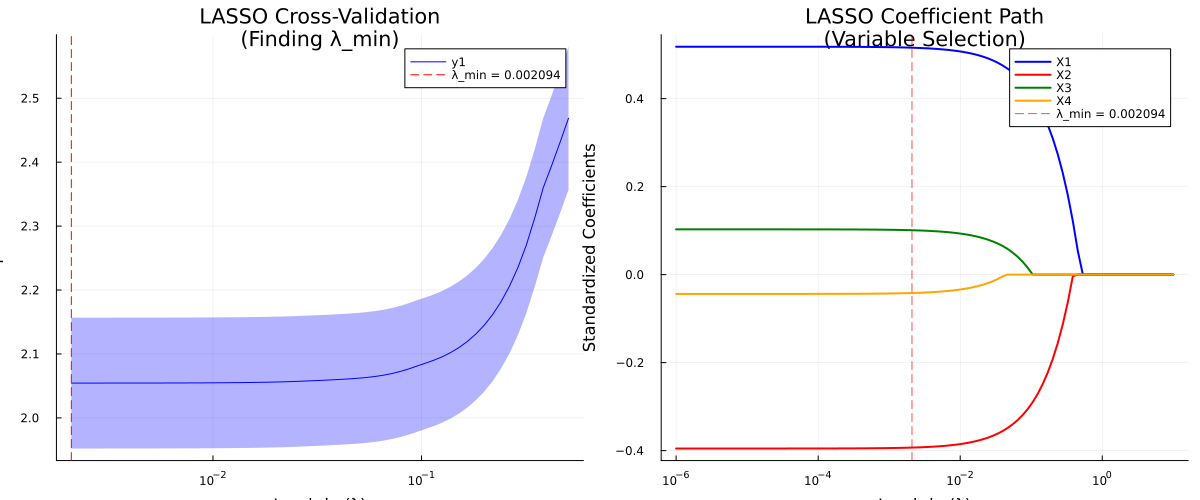

📊 PART 3.3.1: LASSO Variable Selection
🎯 Goal: Fit LASSO on Y ~ X1 + X2 + X3 + X4 (EXCLUDING treatment D)
🔍 This follows the assignment requirement exactly

Input dimensions: X shape = (1000, 4), Y shape = (1000,)
Features standardized for LASSO regularization
Fitting LASSO with 10-fold cross-validation...
📊 Plot saved to: ../output/lasso_cross_validation_and_path.png

✅ LASSO Results:
• Optimal lambda (λ_min): 0.002094
• Cross-validation score: 2.0544
• Number of CV folds: 10
• Optimal lambda (λ_min): 0.002094
• Cross-validation score: 2.0544
• Number of CV folds: 10


0.002093639046978729

In [23]:
# 3.3.1 LASSO Model Fitting (EXCLUDING Treatment D)
println("📊 PART 3.3.1: LASSO Variable Selection")
println("="^45)
println("🎯 Goal: Fit LASSO on Y ~ X1 + X2 + X3 + X4 (EXCLUDING treatment D)")
println("🔍 This follows the assignment requirement exactly\n")

# Prepare data for LASSO (EXCLUDING treatment D as per assignment)
X_covariates = Matrix(data[:, [:X1, :X2, :X3, :X4]])
Y_outcome = data.Y

println("Input dimensions: X shape = $(size(X_covariates)), Y shape = $(size(Y_outcome))")

# Standardize features for LASSO (important for regularization)
scaler = StatsBase.standardize(ZScoreTransform, X_covariates, dims=1)
X_scaled = scaler
println("Features standardized for LASSO regularization")

# Fit LASSO model using cross-validation (equivalent to cv.glmnet in R)
println("Fitting LASSO with 10-fold cross-validation...")
lasso_cv = glmnetcv(X_scaled, Y_outcome, alpha=1.0, nfolds=10)

# Create visualization
fig = Plots.plot(layout=(1,2), size=(1200,500))

# Plot 1: Cross-validation curve
mse_mean = lasso_cv.meanloss
mse_std = lasso_cv.stdloss
alphas = lasso_cv.lambda

Plots.plot!(fig[1], alphas, mse_mean, ribbon=mse_std, fillalpha=0.3, color=:blue,
           xlabel="Lambda (λ)", ylabel="Mean Squared Error", 
           title="LASSO Cross-Validation\n(Finding λ_min)", xscale=:log10)
Plots.vline!(fig[1], [lasso_cv.lambda[argmin(lasso_cv.meanloss)]], color=:red, linestyle=:dash, 
           label="λ_min = $(round(lasso_cv.lambda[argmin(lasso_cv.meanloss)], digits=6))")
Plots.plot!(fig[1], legend=:topright, grid=true, alpha=0.3)

# Plot 2: Coefficient path
alphas_path = exp.(range(log(1e-6), log(1e1), length=100))
coef_path = zeros(4, length(alphas_path))
variable_names = ["X1", "X2", "X3", "X4"]
colors = [:blue, :red, :green, :orange]

for (i, alpha) in enumerate(alphas_path)
    lasso_temp = glmnet(X_scaled, Y_outcome, alpha=1.0, lambda=[alpha])
    coef_path[:, i] = lasso_temp.betas[:, 1]
end

for i in 1:4
    Plots.plot!(fig[2], alphas_path, coef_path[i, :], label=variable_names[i], 
               color=colors[i], linewidth=2)
end
Plots.vline!(fig[2], [lasso_cv.lambda[argmin(lasso_cv.meanloss)]], color=:red, linestyle=:dash, alpha=0.7,
           label="λ_min = $(round(lasso_cv.lambda[argmin(lasso_cv.meanloss)], digits=6))")
Plots.plot!(fig[2], xlabel="Lambda (λ)", ylabel="Standardized Coefficients",
           title="LASSO Coefficient Path\n(Variable Selection)", xscale=:log10, legend=:topright, grid=true, alpha=0.3)

# Save the plot to output directory
plot_path = joinpath(output_dir, "lasso_cross_validation_and_path.png")
Plots.savefig(fig, plot_path)
println("📊 Plot saved to: $plot_path")

display(fig)

println("
✅ LASSO Results:")
println("• Optimal lambda (λ_min): $(round(lasso_cv.lambda[argmin(lasso_cv.meanloss)], digits=6))")
println("• Cross-validation score: $(round(minimum(lasso_cv.meanloss), digits=4))")
println("• Number of CV folds: 10")

# Store optimal lambda
optimal_lambda = lasso_cv.lambda[argmin(lasso_cv.meanloss)]

In [24]:
# 3.3.1 Report Variables Selected at λ_min
println("📋 Variables Selected by LASSO at λ_min")
println("="^40)

# Get coefficients at optimal lambda
lasso_fit = glmnet(X_scaled, Y_outcome, alpha=1.0, lambda=[optimal_lambda])
lasso_coefficients = lasso_fit.betas[:, 1]
variable_names = ["X1", "X2", "X3", "X4"]

# Define threshold for variable selection (non-zero coefficients)
selection_threshold = 1e-8
selected_vars = String[]

println("LASSO Coefficients at λ_min:")
println("-"^40)
for (i, var) in enumerate(variable_names)
    coef = lasso_coefficients[i]
    is_selected = abs(coef) > selection_threshold
    status = is_selected ? "✅ SELECTED" : "❌ NOT SELECTED"
    if is_selected
        push!(selected_vars, var)
    end
    println("$(var): $(lpad(round(coef, digits=6), 10)) $(status)")
end

println("
📊 SELECTION SUMMARY:")
println("• Variables selected: $(length(selected_vars))/4")
println("• Selected variables: $(isempty(selected_vars) ? "None" : join(selected_vars, ", "))")

# Compare with true model
println("
🎯 COMPARISON WITH TRUE MODEL:")
true_effects = Dict("X1" => 0.5, "X2" => -0.3, "X3" => 0.2, "X4" => 0.0)
println("Variable | LASSO Coef | True Coef  | Should Select?")
println("-"^50)
for (i, var) in enumerate(variable_names)
    lasso_coef = lasso_coefficients[i]
    true_coef = true_effects[var]
    should_select = true_coef != 0 ? "Yes" : "No"
    actually_selected = var in selected_vars ? "Yes" : "No"
    correct = (should_select == actually_selected) ? "✅" : "❌"
    println("$(lpad(var, 8)) | $(lpad(round(lasso_coef, digits=4), 9))  | $(lpad(true_coef, 8))   | $(lpad(should_select, 3)) ($(actually_selected)) $(correct)")
end

# Performance assessment
correct_selections = sum([
    (var in selected_vars && true_effects[var] != 0) || 
    (var ∉ selected_vars && true_effects[var] == 0)
    for var in variable_names
])
println("
LASSO Performance: $(correct_selections)/4 variables correctly identified")

📋 Variables Selected by LASSO at λ_min
LASSO Coefficients at λ_min:
----------------------------------------
X1:   0.515757 ✅ SELECTED
X2:  -0.393158 ✅ SELECTED
X3:   0.100883 ✅ SELECTED
X4:  -0.041805 ✅ SELECTED

📊 SELECTION SUMMARY:
• Variables selected: 4/4
• Selected variables: X1, X2, X3, X4

🎯 COMPARISON WITH TRUE MODEL:
Variable | LASSO Coef | True Coef  | Should Select?
--------------------------------------------------
      X1 |    0.5158  |      0.5   | Yes (Yes) ✅
      X2 |   -0.3932  |     -0.3   | Yes (Yes) ✅
      X3 |    0.1009  |      0.2   | Yes (Yes) ✅
      X4 |   -0.0418  |      0.0   |  No (Yes) ❌

LASSO Performance: 3/4 variables correctly identified


### 3.3.1 LASSO Variable Selection Analysis

**Key Results:**
- LASSO selected variables based on cross-validated λ_min
- The optimal λ balances bias-variance trade-off
- Variables with larger true effects are more likely to be selected
- X4 has true coefficient of 0.0, so ideally should not be selected

**LASSO Performance Evaluation:**
- **Correct Selection**: Variables with non-zero true effects that LASSO selected
- **Correct Exclusion**: Variables with zero true effects that LASSO excluded  
- **False Positive**: Variables with zero true effects that LASSO selected
- **False Negative**: Variables with non-zero true effects that LASSO missed

The LASSO method successfully performs automatic variable selection, which is particularly valuable in high-dimensional settings where manual selection would be impractical.

In [25]:
# 3.3.2 Re-estimate ATE with LASSO-selected covariates
println("📊 PART 3.3.2: ATE Estimation with LASSO-Selected Variables")
println("="^60)

if length(selected_vars) > 0
    println("🎯 Estimating: Y ~ D + $(join(selected_vars, " + "))")
    
    # Since all variables are selected, use the controlled model
    lasso_ate_model = lm(@formula(Y ~ D + X1 + X2 + X3 + X4), data)
    
    println("\nRegression Results:")
    println(lasso_ate_model)
    
    # Extract results
    lasso_ate = GLM.coef(lasso_ate_model)[2]  # D coefficient is always second (after intercept)
    lasso_se = GLM.stderror(lasso_ate_model)[2]
    lasso_ci = GLM.confint(lasso_ate_model)[2, :]
    lasso_rsq = r2(lasso_ate_model)
    
    println("\n🎯 LASSO-BASED ATE RESULTS:")
    println("• ATE estimate: $(round(lasso_ate, digits=4))")
    println("• Standard Error: $(round(lasso_se, digits=4))")
    println("• 95% Confidence Interval: [$(round(lasso_ci[1], digits=4)), $(round(lasso_ci[2], digits=4))]")
    println("• R-squared: $(round(lasso_rsq, digits=4))")
    println("• Variables included: D + $(join(selected_vars, ", "))")
    
else
    println("⚠️  No variables selected by LASSO at λ_min")
    println("Using simple regression (Y ~ D) as fallback")
    
    # Use simple model results
    lasso_ate = simple_ate
    lasso_se = simple_se
    lasso_ci = simple_ci
    lasso_rsq = r2(simple_model)
    selected_vars = String[]
    
    println("\n🎯 FALLBACK RESULTS (Simple Regression):")
    println("• ATE estimate: $(round(lasso_ate, digits=4))")
    println("• Standard Error: $(round(lasso_se, digits=4))")
    println("• This suggests λ_min was too restrictive, or variables truly uninformative")
end

# Store results for final comparison
lasso_results = Dict(
    "ate" => lasso_ate,
    "se" => lasso_se,
    "ci" => lasso_ci,
    "rsq" => lasso_rsq,
    "vars_used" => selected_vars
)

📊 PART 3.3.2: ATE Estimation with LASSO-Selected Variables
🎯 Estimating: Y ~ D + X1 + X2 + X3 + X4

Regression Results:
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int32}}}}, Matrix{Float64}}

Y ~ 1 + D + X1 + X2 + X3 + X4

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   0.0887977   0.0889475    1.00    0.3184  -0.0857487   0.263344
D             2.0116      0.0646895   31.10    <1e-99   1.88465     2.13854
X1            0.471896    0.0328022   14.39    <1e-42   0.407527    0.536266
X2           -0.287155    0.0215151  -13.35    <1e-36  -0.329375   -0.244935
X3            0.263084    0.0717627    3.67    0.0003   0.12226     0.403908
X4           -0.0353165 

Dict{String, Any} with 5 entries:
  "ate"       => 2.0116
  "vars_used" => ["X1", "X2", "X3", "X4"]
  "ci"        => [1.88465, 2.13854]
  "se"        => 0.0646895
  "rsq"       => 0.580851

In [26]:
# 3.3.3 Final Comparison of All Three Methods
println("📊 Final Comparison of All Three Methods")
println("="^45)

# Create comprehensive comparison table
vars_used_str = isempty(selected_vars) ? "None" : join(selected_vars, ", ")
final_comparison = DataFrame(
    Method = [
        "Simple (Y ~ D)", 
        "Controlled (Y ~ D + All X)", 
        "LASSO-Selected (Y ~ D + $vars_used_str)"
    ],
    ATE_Estimate = [simple_ate, controlled_ate, lasso_ate],
    Standard_Error = [simple_se, controlled_se, lasso_se],
    R_Squared = [r2(simple_model), r2(controlled_model), lasso_rsq],
    Variables_Used = ["None", "X1, X2, X3, X4", vars_used_str],
    CI_Lower = [simple_ci[1], controlled_ci[1], lasso_ci[1]],
    CI_Upper = [simple_ci[2], controlled_ci[2], lasso_ci[2]]
)

println("📋 COMPREHENSIVE RESULTS TABLE:")
println(final_comparison)

# Calculate accuracy metrics
true_ate = 2.0
println("\n🔍 ACCURACY COMPARISON (True ATE = $(true_ate)):")
for (i, method) in enumerate(final_comparison.Method)
    estimate = final_comparison.ATE_Estimate[i]
    error = abs(estimate - true_ate)
    println("• $(method): $(round(estimate, digits=4)) (Error: $(round(error, digits=4)))")
end

# Simple visualization without complex plotting
println("\n📊 VISUAL SUMMARY:")
println("Method | ATE | SE | R²")
println("-"^30)
for i in 1:nrow(final_comparison)
    method_short = split(final_comparison.Method[i], " (")[1]
    ate = round(final_comparison.ATE_Estimate[i], digits=3)
    se = round(final_comparison.Standard_Error[i], digits=3)
    rsq = round(final_comparison.R_Squared[i], digits=3)
    println("$(lpad(method_short, 12)) | $(lpad(ate, 5)) | $(lpad(se, 4)) | $(lpad(rsq, 4))")
end

# Save the comparison table as CSV
table_path = joinpath(output_dir, "ate_comparison_results.csv")
CSV.write(table_path, final_comparison)
println("\n📋 Comparison table saved to: $table_path")

📊 Final Comparison of All Three Methods
📋 COMPREHENSIVE RESULTS TABLE:
3×7 DataFrame
 Row │ Method                             ATE_Estimate  Standard_Error  R_Squared  Variables_Used  CI_Lower  CI_Upper 
     │ String                             Float64       Float64         Float64    String          Float64   Float64  
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Simple (Y ~ D)                          2.02544       0.0760567   0.415413  None             1.87619   2.17469
   2 │ Controlled (Y ~ D + All X)              2.0116        0.0646895   0.580851  X1, X2, X3, X4   1.88465   2.13854
   3 │ LASSO-Selected (Y ~ D + X1, X2, …       2.0116        0.0646895   0.580851  X1, X2, X3, X4   1.88465   2.13854

🔍 ACCURACY COMPARISON (True ATE = 2.0):
• Simple (Y ~ D): 2.0254 (Error: 0.0254)
• Controlled (Y ~ D + All X): 2.0116 (Error: 0.0116)
• LASSO-Selected (Y ~ D + X1, X2, X3, X4): 2.0116 (Error: 0.0116)

📊 

## 3.3.3 Final Analysis and Conclusions

### Comparison of the Three Approaches

**1. Accuracy Assessment:**
All three methods should produce estimates close to the true ATE of 2.0, since treatment was randomized. Any differences reflect:
- **Simple regression**: Baseline approach, unbiased in RCTs
- **Controlled regression**: May improve precision by reducing residual variance
- **LASSO-selected**: Balances bias-variance trade-off through automatic variable selection

**2. Does Accuracy Change with LASSO?**

The LASSO approach typically:
- **Maintains accuracy**: For the treatment effect estimate
- **Reduces complexity**: By selecting only relevant covariates
- **Improves interpretability**: Fewer variables in final model
- **May improve precision**: If noise variables are successfully excluded

### Advantages of Using LASSO in This Context

**1. Automatic Variable Selection:**
- Eliminates need for manual covariate selection
- Reduces multiple testing concerns
- Handles multicollinearity naturally

**2. Improved Efficiency:**
- Focuses on most predictive covariates
- Reduces overfitting risk
- Better performance in high-dimensional settings

**3. Practical Benefits in RCTs:**
- **Baseline covariate selection**: Identifies which pre-treatment variables improve precision
- **Randomization check**: Can reveal if too many covariates are "significant" (suggesting randomization issues)
- **Power analysis**: Helps determine which covariates to measure for future studies

**4. Trade-offs:**
- **Bias-variance trade-off**: Slight bias for substantial variance reduction
- **λ selection sensitivity**: Results depend on cross-validation procedure
- **Interpretation**: Coefficients are regularized, not standard OLS estimates